# **Компьютерная работа №1**

Многомерные статистические методы

2024-25 гг. — 2 курс

Выполнили: Симакова Алёна, Штанько Константин, Малышкина Мария, Кукатова Арина, Украинский Евгений

# Постановка задачи

**Описание исходных данных**

Зависимая переменная: государственные расходы на образование в процентах от ВВП


Объясняющие факторы:

*   Уровень завершения начальной школы в процентах от соответствующей возрастной группы
*   Соотношение учеников и учителей на уровне начального образования
*   Соотношение учеников и учителей на уровне среднего образования
*   Уровень зачисления в начальную школу в процентах от населения
*   Общий уровень зачисления в школу в процентах от населения
*   Уровень зачисления в среднюю школу в процентах от населения

Обоснование репрезентативности: данные взяты по 185 странам, что говорит о достаточном объеме выборки, представлены страны со всех континетов, развитые и развивающиеся, с различным уровнем образования.

**Основные гипотезы исследования**
*   Государственные расходы на образование положительно зависят от уровня завершения начальной школы/ от уровня зачисления в начальную и среднюю школу
имеют отрицательную зависимость с соотношением учеников на учителей на уровне начального / среднего образования
*   Целевая переменная государственные расходы на образование в процентах от ВВП распределена в соответствии с нормальным законом
*   Имеется тесная взаимосвязь между уровнем зачисления в начальную школу и уровнем зачисления в среднюю школу, а также между уровнем зачисления в начальную школу и уровнем завершения начальной школы

# Основные характеристики зависимой переменной

Импортируем необходимые для работы библиотеки

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro, norm, probplot, levene, f_oneway, kruskal
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from scipy.stats import kstest, norm

Импортируем исходные данные и проверим на наличие пропусков

In [3]:
data = pd.read_excel('world-education-data.xlsx', sheet_name='Data')
data.isna().sum()

GEPG     0
PCRP    27
PTP     31
PTS     55
SEPP     2
SESP    20
SETP    30
dtype: int64

Заполним пропуски средним значением по столбцу

In [4]:
data = data.fillna(data.mean())
data.head()

,GEPG,PCRP,PTP,PTS,SEPP,SESP,SETP
0,0.470743,90.038508,23.013498,16.723158,87.445641,44.514751,41.027226
1,1.536880,101.737763,6.721310,4.979320,104.431992,90.553101,35.096611
2,1.566736,93.985718,44.634940,16.723158,114.556168,83.760096,41.027226
3,1.858590,95.303070,23.659180,16.723158,97.433752,93.835940,18.173412
4,1.914720,58.981491,23.013498,16.723158,112.744295,26.939825,4.574040


Для дальнейшего анализа будем использовать логарифмированное значение целевой переменной

In [5]:
qoli = data['GEPG']
qoli = np.log(qoli)
data['GEPG'] = np.log(data['GEPG'])
data.head()

,GEPG,PCRP,PTP,PTS,SEPP,SESP,SETP
0,-0.753444,90.038508,23.013498,16.723158,87.445641,44.514751,41.027226
1,0.429754,101.737763,6.721310,4.979320,104.431992,90.553101,35.096611
2,0.448995,93.985718,44.634940,16.723158,114.556168,83.760096,41.027226
3,0.619818,95.303070,23.659180,16.723158,97.433752,93.835940,18.173412
4,0.649571,58.981491,23.013498,16.723158,112.744295,26.939825,4.574040


Характеристики зависимой переменной

In [6]:
statistics = qoli.describe()
statistics['range'] = statistics['max'] - statistics['min']
statistics['IQR'] = statistics['75%'] - statistics['25%']
statistics['kurtosis'] = qoli.kurt()
statistics['skewness'] = qoli.skew()
new_indexes = ['median' if x == '50%' else x for x in list(statistics.index)]
statistics.index = new_indexes
print(f"Среднее значение: {statistics['mean']:.4f}")
print(f"Стандартное отклонение: {statistics['std']:.4f}")
print(f"Дисперсия: {statistics['std'] ** 2:.4f}")
print(f"Минимальное значение: {statistics['min']:.4f}")
print(f"Квартиль 0.25: {statistics['25%']:.4f}")
print(f"Медиана: {statistics['median']:.4f}")
print(f"Квартиль 0.75: {statistics['75%']:.4f}")
print(f"Максимальное значение: {statistics['max']:.4f}")
print(f"Размах: {statistics['range']:.4f}")
print(f"Мода: {qoli.mode()}")
print(f"Коэффициент вариации: {statistics['std']/statistics['mean']:.4f}")

Среднее значение: 1.4353
Стандартное отклонение: 0.3782
Дисперсия: 0.1431
Минимальное значение: -0.7534
Квартиль 0.25: 1.2307
Медиана: 1.4590
Квартиль 0.75: 1.6661
Максимальное значение: 2.5613
Размах: 3.3148
Мода: 0    1.230742
1    1.264162
Name: GEPG, dtype: float64
Коэффициент вариации: 0.2635


**Выводы по целевой переменной:**

- Среднее значение государственных расходов на образование в процентах от ВВП 4,2%
- **Минимальное и максимальное значения (-0.7534 и 2.5613)**(логарифмированные): Разброс данных от -0.7534 до 2.5613. Минимальное значение сильно отличается от среднего,  что может свидетельствовать о выбросах, с которыми впоследствии нужно будет работать
- **Квартили**:
   - 25% данных ниже 1.2307 (Q1).
   - 50% данных ниже 1.4590 (медиана).
   - 75% данных ниже 1.6661 (Q3).
Медиана близка к среднему значению (1.4353), что может указывать на симметричное распределение данных.
IQR вычисляется как разница между Q3 и Q1: 1.6661 - 1.2307 = 0.4354.

- **Медиана (1.4590)**: Медиана близка к среднему значению, что может указывать на симметричное распределение данных.

- **Размах (3.3148)**: Разница между максимальным и минимальным значениями довольно велика, что указывает или на значительный разброс данных, или на наличие выбросов.

- **Мода**: Наиболее часто встречающиеся значения — 1.230742 и 1.264162.
Они близки к первому квартилю (Q1 = 1.2307), что может указывать на то, что данные в этой области имеют высокую концентрацию.

- **Коэффициент вариации (0.2635)**: Коэффициент вариации показывает, что относительная изменчивость данных составляет около 26.35%, что указывает на умеренную изменчивость.



# Диагностика выбросов

Изучим наличие нетипичных и аномальных наблюдений целевой переменной, построим ящичковую диаграмму.

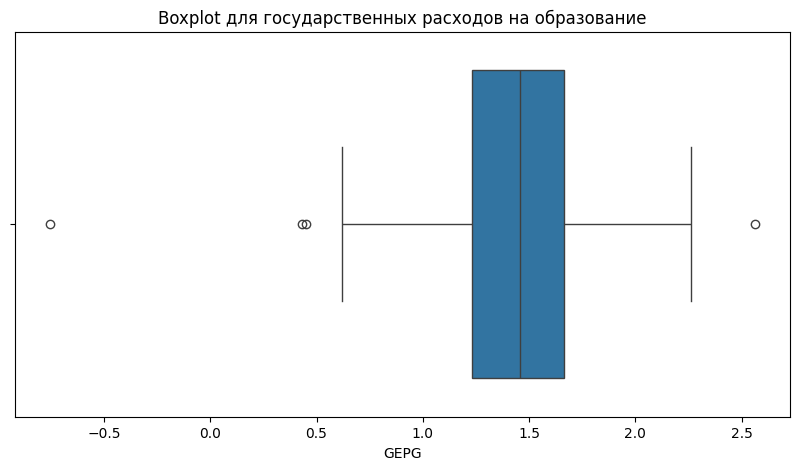

Интерквартильный размах (IQR): 0.4354
Таким образом, по правилу 1,5IQR было выявлено следующие 4 выброса:
-0.753444
 0.429754
 0.448995
 2.561327
По правилу 3σ:
Нижняя граница (μ - 3σ): 0.3005828201891032
Верхняя граница (μ + 3σ): 2.5700568682152025
Выбросы:
0   -0.753444
Name: GEPG, dtype: float64
Таким образом, по правилу 3IQR был выявлен следующий 1 выброс:
-0.753444


In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=qoli)
plt.title('Boxplot для государственных расходов на образование')
plt.show()
print(f"Интерквартильный размах (IQR): {statistics['IQR']:.4f}")
outliers = qoli[(qoli < (statistics['25%'] - 1.5 * statistics['IQR'])) | (qoli > (statistics['75%'] + 1.5 * statistics['IQR']))]
print(f"Таким образом, по правилу 1,5IQR было выявлено следующие {len(outliers)} выброса:")
print(outliers.to_string(index=False))
qoli_wo = qoli[~qoli.isin(outliers)]
data_wo = data[~data['GEPG'].isin(outliers)]
lower_bound = statistics['mean'] - 3 * statistics['std']
upper_bound = statistics['mean'] + 3 * statistics['std']
outliers1 = qoli[(qoli < lower_bound) | (qoli > upper_bound)]
print('По правилу 3σ:')
print("Нижняя граница (μ - 3σ):", lower_bound)
print("Верхняя граница (μ + 3σ):", upper_bound)
print("Выбросы:")
print(outliers1)
outliers2 = qoli[(qoli < (statistics['25%'] - 3 * statistics['IQR'])) | (qoli > (statistics['75%'] + 3 * statistics['IQR']))]
print(f"Таким образом, по правилу 3IQR был выявлен следующий {len(outliers2)} выброс:")
print(outliers2.to_string(index=False))

- **Выбросы по правилу 1,5IQR**: Было выявлено 4 выброса: -0.753444, 0.429754, 0.448995 и 2.561327. Эти значения находятся за пределами типичного диапазона данных и могут искажать анализ.

- **Выбросы по правилу 3σ**: По этому правилу был выявлен один выброс: -0.753444. Это наблюдение значительно отклоняется от среднего и может быть результатом ошибки измерения или редкого события.

- **Правило 3σ:**
 Около 99.7% данных лежат в пределах трёх стандартных отклонений (σ) от среднего значения (µ). Наблюдения, выходящие за пределы этого диапазона, считаются выбросами.
Нижняя и верхняя граница по этому правилу [0,300582820; 2,57005687].
 По правилу 3σ был выявлен **один выброс**: **-0.753444**. Это наблюдение значительно меньше нижней границы (0.3005828201891032), что делает его экстремальным отклонением от среднего.


**Ящичковая диаграмма после удаления выбросов**

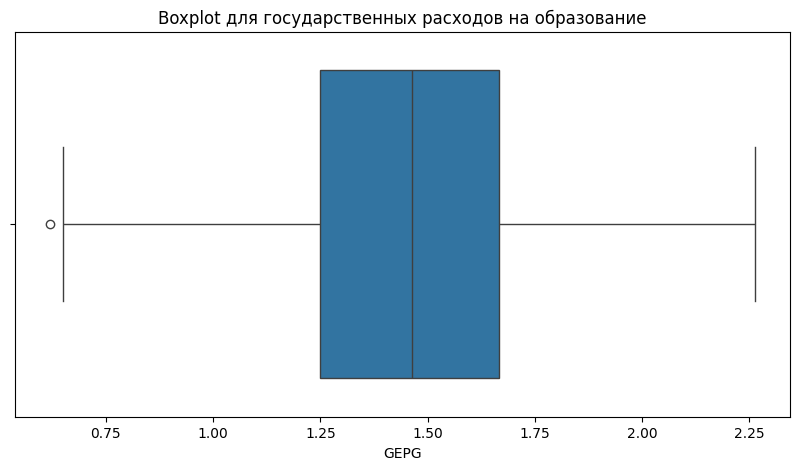

In [8]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=qoli_wo)
plt.title('Boxplot для государственных расходов на образование')
plt.show()

 Убедимся, что мы исключили все аномальные наблюдения, проведя проверку гипотезы о наличии аномальных наблюдений с помощью критерия Граббса/Рознера

In [9]:
from rpy2.robjects import pandas2ri, FloatVector
from rpy2.robjects.packages import importr
pandas2ri.activate()
outliers = importr('outliers')
vibrosi = qoli_wo.to_numpy()
r_data = FloatVector(vibrosi)
grubbs_test = outliers.grubbs_test(r_data)
print(grubbs_test)


	Grubbs test for one outlier

data:  c(0.619818139499079, 0.649571428134704, 0.699128464463823, 0.774258605720684, 0.790428135746467, 0.80970282639263, 0.841701772310687, 0.884928055765995, 0.903189247816659, 0.933142980098833, 0.939211756616865, 0.949323127596542, 0.954187125426286, 0.96813905358554, 0.980032349443407, 0.980830534510905, 1.00968270801069, 1.01034421982649, 1.04188534749515, 1.04562177973871, 1.04562177973871, 1.07307794886643, 1.07766438675525, 1.09380743783811, 1.09441056511125, 1.09441056511125, 1.09784086619829, 1.12304793458684, 1.1394599177398, 1.15113828939424, 1.15113828939424, 1.1549957846701, 1.16114139728792, 1.16843902315021, 1.19028248266387, 1.19820718021312, 1.19837909989127, 1.20991211514889, 1.21460703502866, 1.22826530527256, 1.23074226881439, 1.23074226881439, 1.23074226881439, 1.23074226881439, 1.23228018639205, 1.24875325489904, 1.26299048469151, 1.26299048469151, 1.26299048469151, 1.26416153557941, 1.26416153557941, 1.26416153557941, 1.2641615355

Гипотеза о наличии аномальных наблюдений не отвергается, поскольку p-value = 0.7563 > alpha=0.05.  Это означает, что в данных нет статистически значимых аномальных наблюдений.

In [10]:
env_stats = importr("EnvStats")
rosner_test = env_stats.rosnerTest(r_data, k=1)
print(rosner_test)


Results of Outlier Test
-------------------------

Test Method:                     Rosner's Test for Outliers

Hypothesized Distribution:       Normal

Data:                            c(0.619818139499079, 0.649571428134704, 0.699128464463823, 0.774258605720684, 0.790428135746467, 0.80970282639263, 0.841701772310687, 0.884928055765995, 0.903189247816659, 0.933142980098833, 0.939211756616865, 0.949323127596542, 0.954187125426286, 0.96813905358554, 0.980032349443407, 0.980830534510905, 1.00968270801069, 1.01034421982649, 1.04188534749515, 1.04562177973871, 1.04562177973871, 1.07307794886643, 1.07766438675525, 1.09380743783811, 1.09441056511125, 1.09441056511125, 1.09784086619829, 1.12304793458684, 1.1394599177398, 1.15113828939424, 1.15113828939424, 1.1549957846701, 1.16114139728792, 1.16843902315021, 1.19028248266387, 1.19820718021312, 1.19837909989127, 1.20991211514889, 1.21460703502866, 1.22826530527256, 1.23074226881439, 1.23074226881439, 1.23074226881439, 1.23074226881439, 1.23228

На ящичковой диаграмме (boxplot) наблюдается один выброс, поэтому гиперпараметр k = 1.
Поскольку критерий Рознера не обнаружил выбросов (Number of Outliers Detected: 0), мы не отвергаем нулевую гипотезу. Это означает, что в данных нет статистически значимых аномальных наблюдений и все наблюдения можно считать нормальными (не выбросами) с точки зрения критерия Рознера.

# Проверка соответствия эмпирического распределения нормальному закону

Коэффициент асимметрии: -1.1191
Коэффициент эксцесса: 5.5963


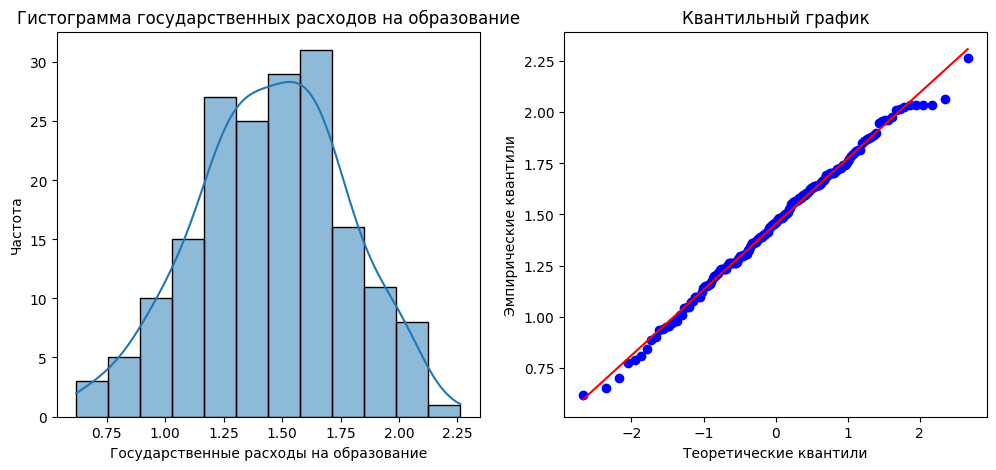

По тесту Шапиро-Уилка p-value составляет 0.6707
Статистика Колмогорова-Смирнова: 0.042395066269576454
P-значение: 0.8869917269038979


In [11]:
print(f"Коэффициент асимметрии: {statistics['skewness']:.4f}")
print(f"Коэффициент эксцесса: {statistics['kurtosis']:.4f}")

figure, (x, y) = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(qoli_wo, kde=True, ax=x)
x.set_title('Гистограмма государственных расходов на образование')
probplot(qoli_wo, plot=y)
y.set_title('Квантильный график')

x.set_xlabel('Государственные расходы на образование')
x.set_ylabel('Частота')
y.set_xlabel('Теоретические квантили')
y.set_ylabel('Эмпирические квантили')

plt.show()

#Проверка гипотезы о нормальном распределении совокупности с использованием статистического критерия (критерий Пирсона, Колмогорова и т.д.)
s, pval = shapiro(qoli_wo)
print(f'По тесту Шапиро-Уилка p-value составляет {pval:.4f}')
ks_statistic, p_value = kstest(qoli_wo, 'norm', args=(np.mean(qoli_wo), np.std(qoli_wo)))
print(f"Статистика Колмогорова-Смирнова: {ks_statistic}")
print(f"P-значение: {p_value}")

- По тесту Шапиро-Уилка p-value = 0,6707, по тесту Колмогорова-Смирнова р значение = 0,89. При уровне значимости 0,05 можно утверждать что гипотеза о принадлежности выборки к нормальному распределению не отвергается на заданном уровне значимости.
- **Коэффициент асимметрии равен -1.1191**, что говорит о существенной левосторонней асимметрии.
- **Коэффициент эксцесса равен 5.5963**, что говорит о существенном островершинном распределении.
- Согласно квантильному графику выборка соответствует нормальному распределению на большей части отрезка наблюдений.


# Корреляционный анализ

**Матрица рассеивания до удаления выбросов**

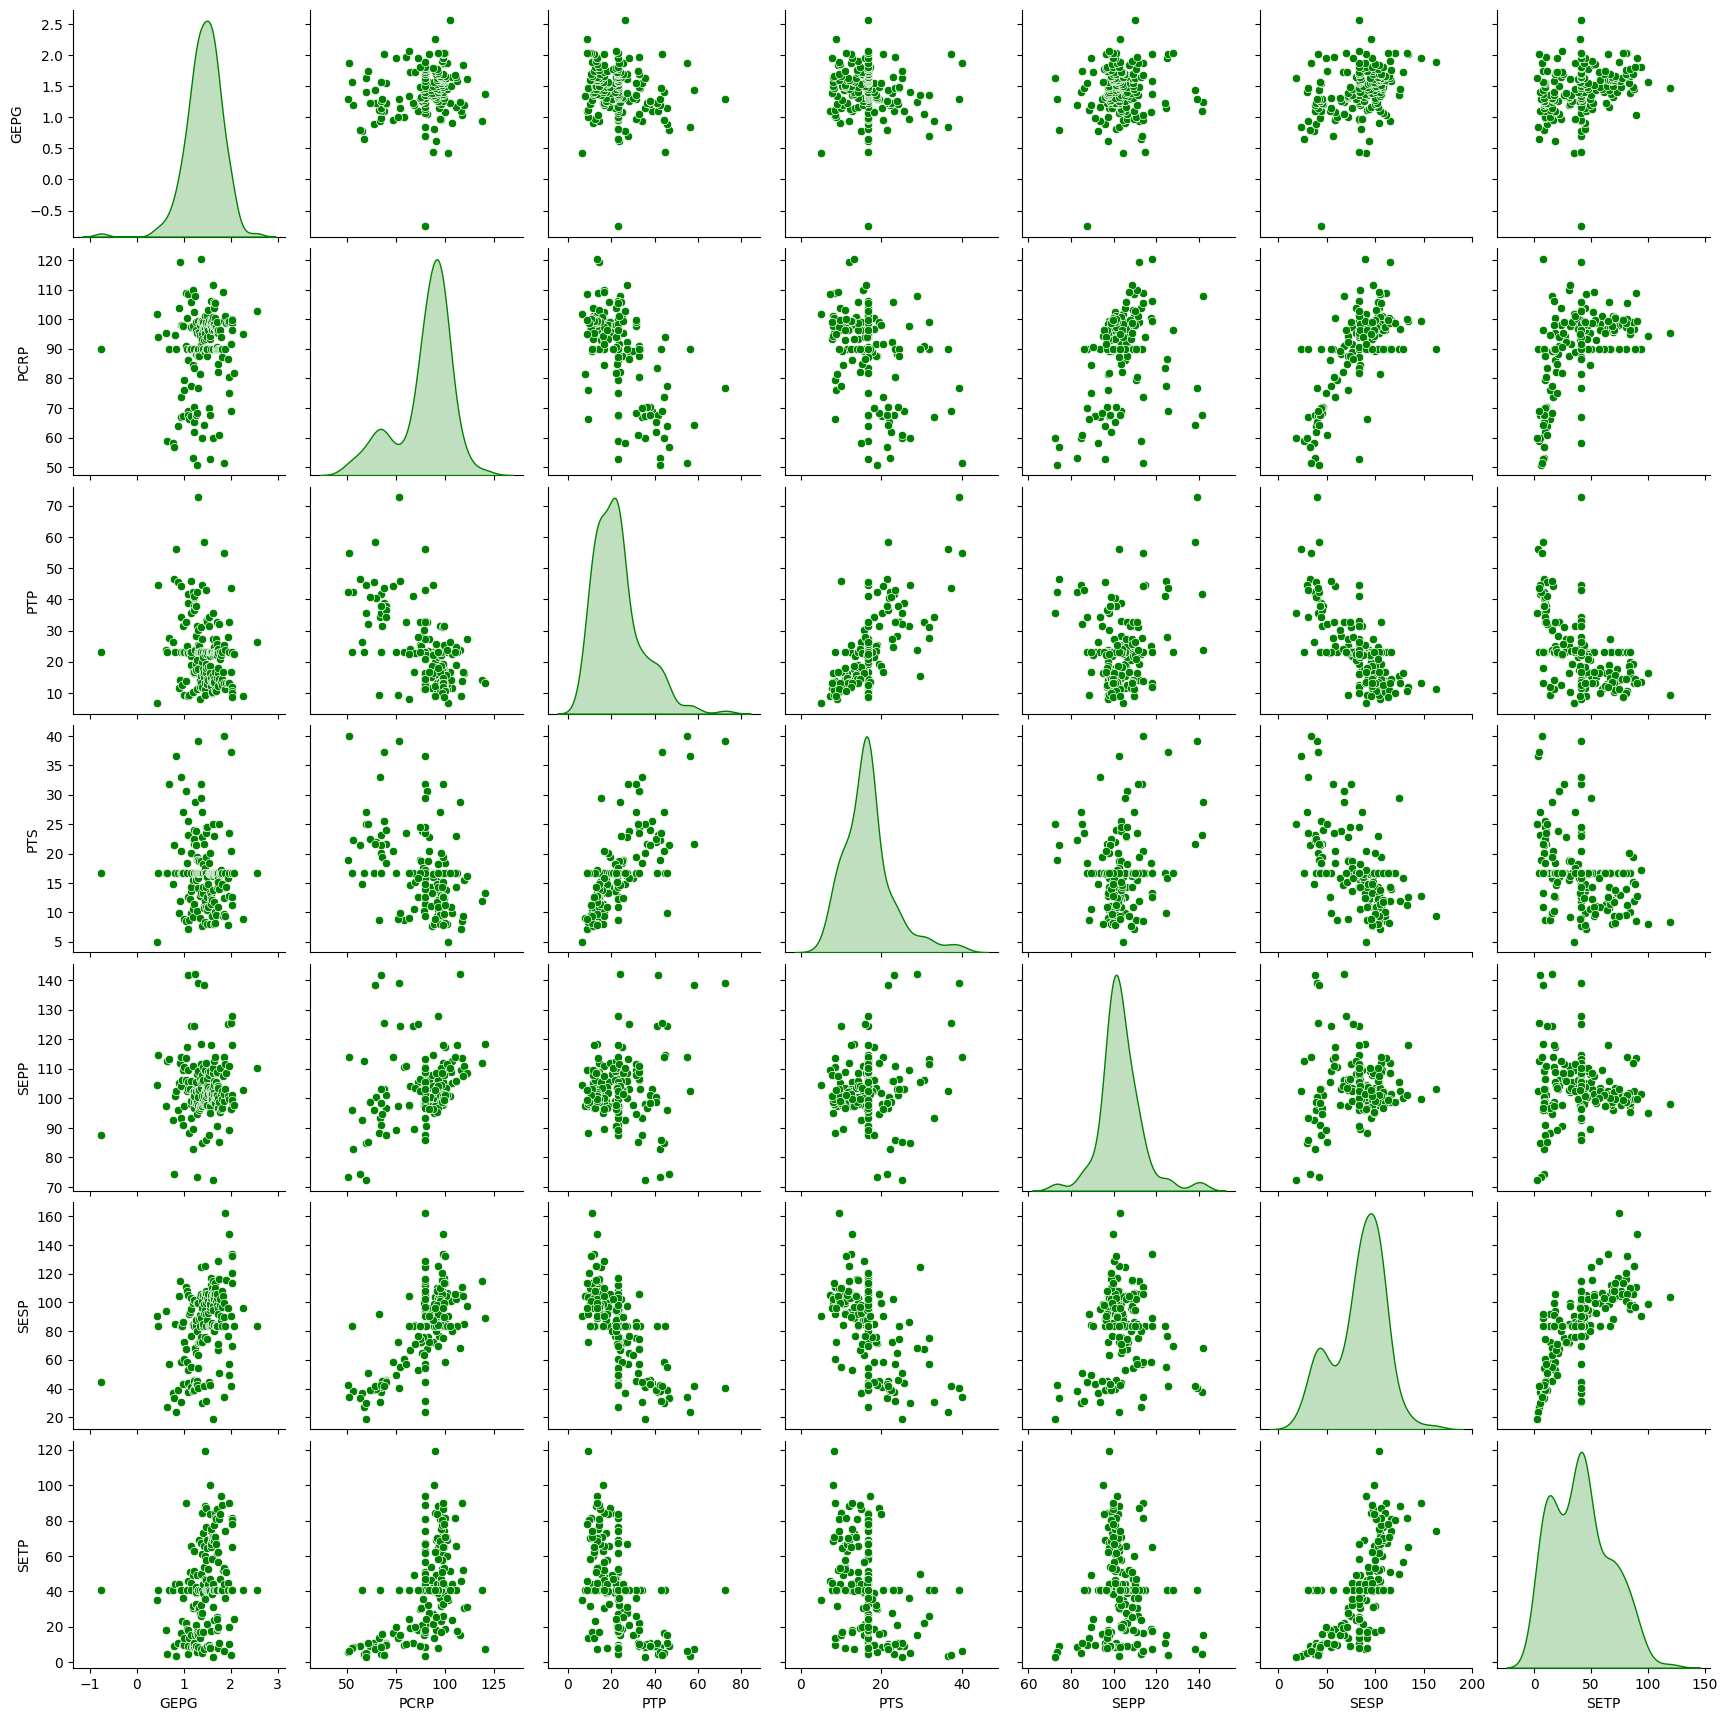

In [12]:
sns.pairplot(data=data, plot_kws={'color': 'green'}, diag_kind='kde', diag_kws={'color': 'green'})

**Матрица рассеивания после удаления выбросов**

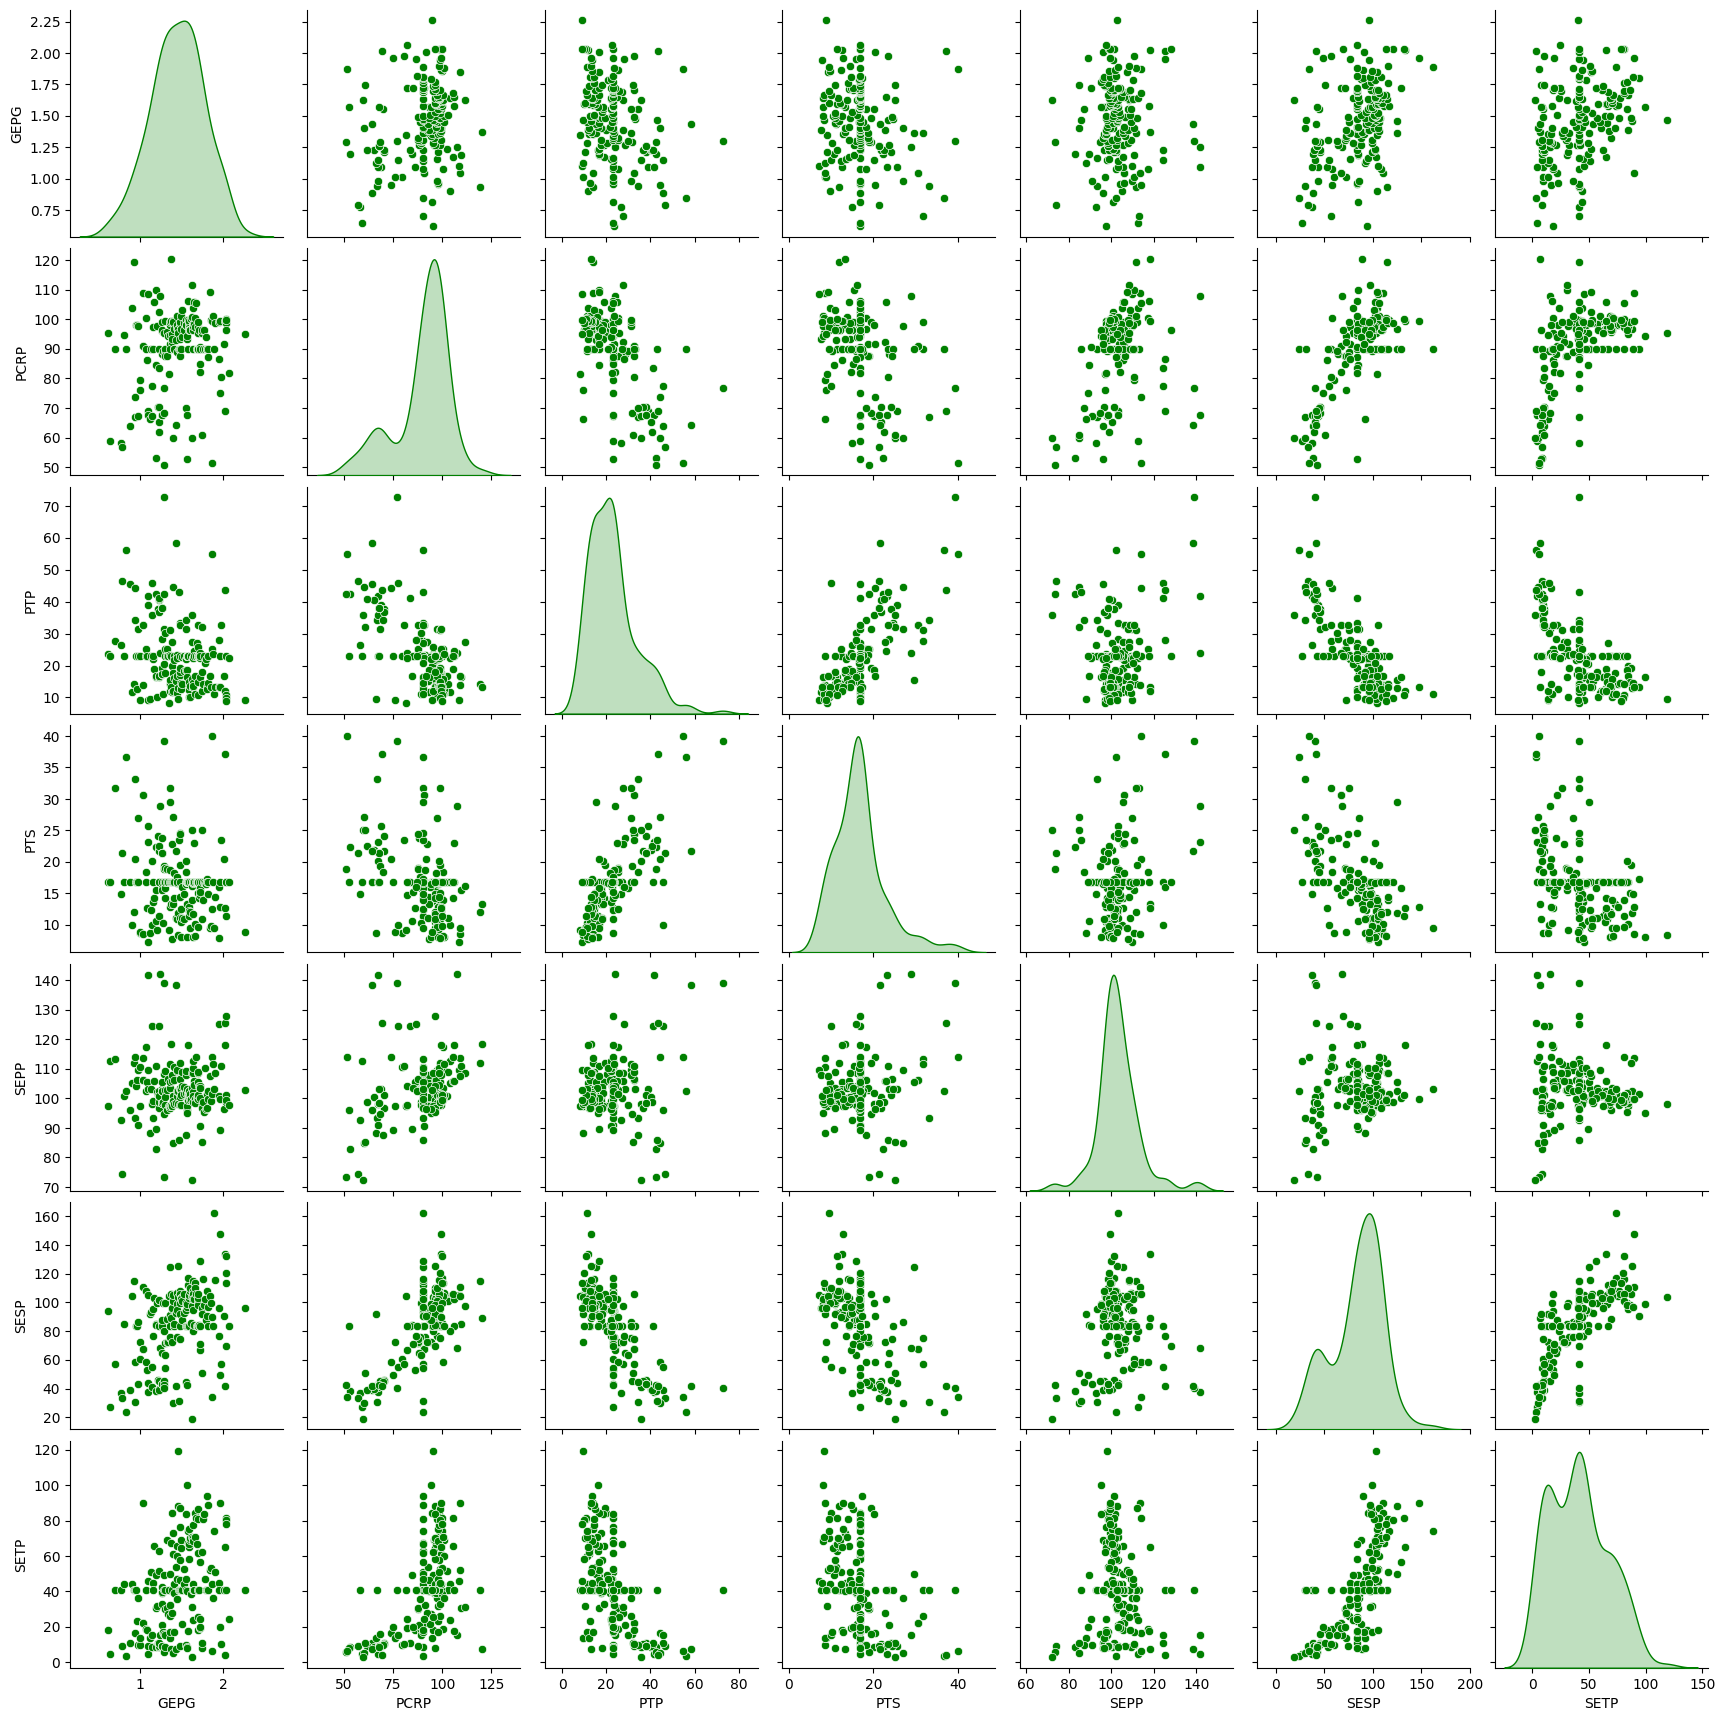

In [13]:
sns.pairplot(data=data_wo, plot_kws={'color': 'green'}, diag_kind='kde', diag_kws={'color': 'green'})

- Можно заметить, что до удаление выбросов, распределение целевой переменной похоже на **нормальное**, но имеет правостороннюю асимметрию и островершинность, что пропадает после удаления выбросов.
- Также можем сделать вывод о том, что целевая переменная нелинейно зависит от объясняющих, так как точки расположены облаками, что усложняет определение положительной или отрицательной зависимости.
- После удаления выбросов, можем выдвинуть гипотезу о наличии **отрицательной зависимости** между государственными расходами на образование в процентах от ВВП и уровнем зачисления в среднюю школу в процентах от населения, а также между государственныеми расходами на образование в процентах от ВВП и общим уровнем зачисления в школу в процентах от населения.
- **Положительная зависимость** наблюдается между соотношением учеников и учителей на уровне начального образования и соотношением учеников и учителей на уровне среднего образования, между соотношением уровня зачисления в среднюю школу в процентах от населения  и общим уровнем зачисления в школу в процентах от населения, между уровнем зачисления в начальную школу в процентах от населения уровня завершения начальной школы в процентах от соответствующей возрастной группы.

**Матрица парных коэффициентов корреляции до удаления выбросов**

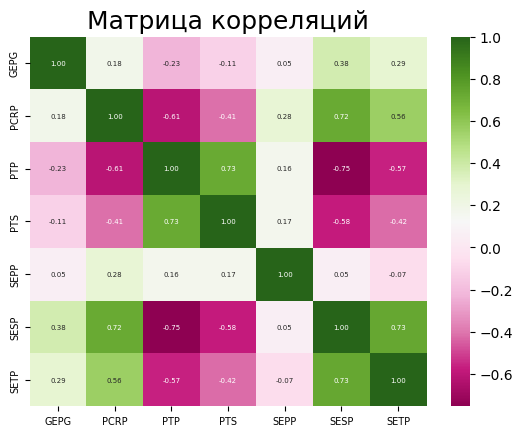

In [14]:
corrgraph = sns.heatmap(data.corr(numeric_only=True), cmap='PiYG', annot=True, fmt='.2f', annot_kws={'size': 5})
corrgraph.set_xticklabels(corrgraph.get_xticklabels(), fontsize=7)
corrgraph.set_yticklabels(corrgraph.get_yticklabels(), fontsize=7)
corrgraph.set_title('Матрица корреляций', fontsize=18)
plt.show()

**Матрица парных коэффициентов корреляции после удаления выбросов**

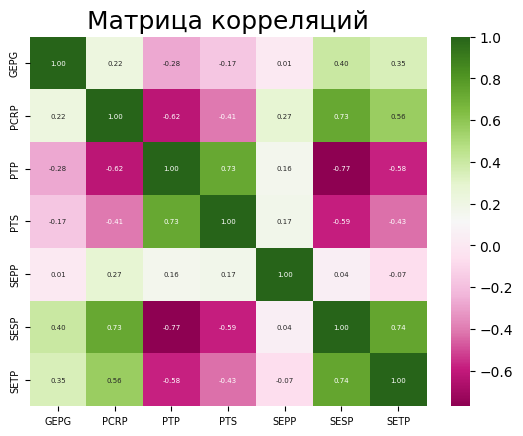

In [15]:
corrgraph = sns.heatmap(data_wo.corr(numeric_only=True), cmap='PiYG', annot=True, fmt='.2f', annot_kws={'size': 5})
corrgraph.set_xticklabels(corrgraph.get_xticklabels(), fontsize=7)
corrgraph.set_yticklabels(corrgraph.get_yticklabels(), fontsize=7)
corrgraph.set_title('Матрица корреляций', fontsize=18)
plt.show()

**Корреляция государственных расходов на образование в процентах от ВВП с другими переменными**:
- Наибольшая корреляция у государственных расходов на образование в процентах от ВВП наблюдается с **уровнем зачисления в среднюю школу в процентах от населения (0.34)** и **общим уровнем зачисления в школу в процентах от населения (0.28)**. Это указывает на умеренную положительную связь между этими переменными.
- Корреляция с остальными переменными слабая (от 0.05 до 0.23).
- **Проблема мультиколлинеарности** наблюдается между уровнем завершения начальной школы в процентах от соответствующей возрастной группы и уровнем зачисления в среднюю школу в процентах от населения (0.72),
между соотношением учеников и учителей на уровне начального образования и уровнем зачисления в среднюю школу в процентах от населения (0.75),
между соотношением учеников и учителей на уровне начального образования и соотношением учеников и учителей на уровне среднего образования (0.73),
между уровнем зачисления в среднюю школу в процентах от населения и общим уровнем зачисления в школу в процентах от населения (0.73),
- После удаления выбросов все коэффициенты матрицы корреляций практически не изменились, значит выбросы несильно влияли на взаимосвязь признаков.


**Проверка значимости коэффициентов корреляции**

Для проверки значимости коэффициентов построим матрицу p-value

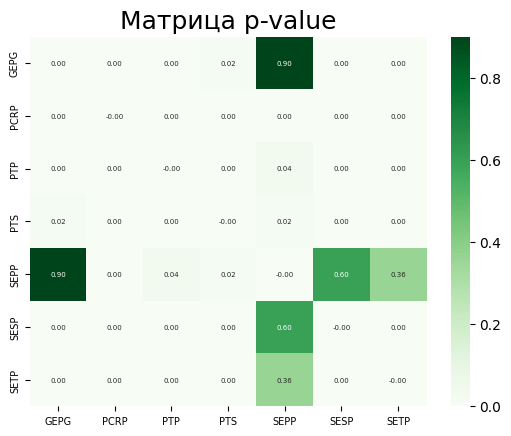

In [16]:
pandas2ri.activate()
stats = importr('stats')
psych = importr('psych')

data_num = data_wo.select_dtypes(exclude=['object'])
data_r = pandas2ri.py2rpy(data_num)
result = psych.corr_test(data_r, adjust="none", ci=True)
corr_matrix = result.rx2('r')
p_matrix = result.rx2('p')
p_matrix = pd.DataFrame(p_matrix, columns=data_wo.corr(numeric_only=True).columns, index=data_wo.corr(numeric_only=True).index)

pgraph = sns.heatmap(p_matrix, cmap='Greens', annot=True, fmt='.2f', annot_kws={'size': 5})
pgraph.set_xticklabels(pgraph.get_xticklabels(), fontsize=7)
pgraph.set_yticklabels(pgraph.get_yticklabels(), fontsize=7)
pgraph.set_title('Матрица p-value', fontsize=18)
plt.show()

- **По матрице p-value** мы анализируем статистическую значимость коэффициентов корреляции, проверяем, что связь между переменными не случайна и является существенной в генеральной совокупности.
- Можно заметить, что статистически не значимыми являются коэффициенты корреляции между переменными **SEPP**(​​уровень зачисления в начальную школу в процентах от населения) и **SETP**(общий уровень зачисления в школу в процентах от населения), **SEPP**(уровень зачисления в начальную школу в процентах от населения) и **SESP**(уровень зачисления в среднюю школу в процентах от населения), **SEPP**(уровень зачисления в начальную школу в процентах от населения) и **GEPG**(государственные расходы на образование в процентах от ВВП).
- Объясняющие переменные, корреляция с целевой переменной которых статистически не значима, стоит удалить в дальнейшем регрессионном анализе.

 **Матрица частных коэффициентов корреляции**

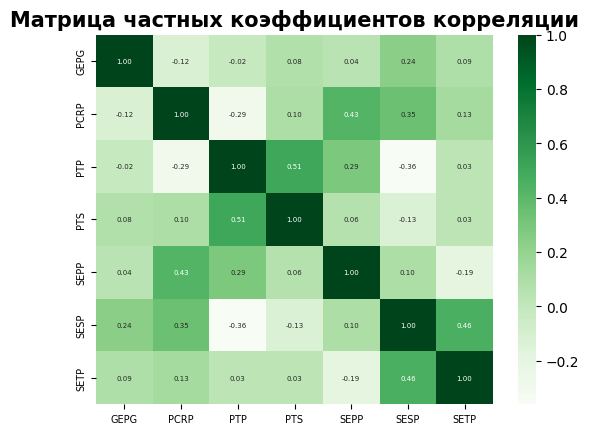

In [17]:
import pingouin as pg
listik = ['GEPG', 'PCRP', 'PTP', 'PTS', 'SEPP', 'SESP', 'SETP']
matrix = np.ones((7,7)).astype('float')
for i in range(7):
    for j in range(7):
        if i == j:
            pass
        else:
            matrix[i, j] = round(float(pg.partial_corr(data=data_num, x=listik[i], y=listik[j], covar=[x for x in listik if x not in [listik[i], listik[j]]])['r'][0]), 2)

chast_graph = sns.heatmap(matrix, cmap='Greens', annot=True, fmt='.2f', annot_kws={'size': 5})
chast_graph.set_xticklabels(pgraph.get_xticklabels(), fontsize=7)
chast_graph.set_yticklabels(pgraph.get_yticklabels(), fontsize=7)
chast_graph.set_title('Матрица частных коэффициентов корреляции', fontsize=15, fontweight='bold')
plt.show()

**Сравнение парных и частных коэффициентов корреляции, выводы о характере взаимосвязей**

In [18]:
for i in range(7):
    for j in range(7):
        if i != j and i < j:
                print(f'Интервальная оценка частного коэффициента корреляции между {listik[i]} и {listik[j]}:')
                abc = pg.partial_corr(data=data_num, x=listik[i], y=listik[j], covar=[x for x in listik if x not in [listik[i], listik[j]]])['CI95%'][0]
                print(f'min: {abc[0]}, max: {abc[1]}')
                if abc[0] <= 0 and abc[1] >= 0:
                     print('Коэффициент незначим, так как 0 входит в интервальную оценку\n')
                else:
                     print('Коэффициент значим, так как 0 не входит в интервальную оценку\n')

Интервальная оценка частного коэффициента корреляции между GEPG и PCRP:
min: -0.27, max: 0.02
Коэффициент незначим, так как 0 входит в интервальную оценку

Интервальная оценка частного коэффициента корреляции между GEPG и PTP:
min: -0.16, max: 0.13
Коэффициент незначим, так как 0 входит в интервальную оценку

Интервальная оценка частного коэффициента корреляции между GEPG и PTS:
min: -0.07, max: 0.22
Коэффициент незначим, так как 0 входит в интервальную оценку

Интервальная оценка частного коэффициента корреляции между GEPG и SEPP:
min: -0.11, max: 0.18
Коэффициент незначим, так как 0 входит в интервальную оценку

Интервальная оценка частного коэффициента корреляции между GEPG и SESP:
min: 0.1, max: 0.38
Коэффициент значим, так как 0 не входит в интервальную оценку

Интервальная оценка частного коэффициента корреляции между GEPG и SETP:
min: -0.05, max: 0.24
Коэффициент незначим, так как 0 входит в интервальную оценку

Интервальная оценка частного коэффициента корреляции между PCRP и P

Построив матрицу частных коэффициентов корреляции можно заметить, что ни одна объясняющая переменная тесно не связана с целевой, что может затруднить дальнейшее построение регрессионной модели.

Значения частных коэффициентов сильно отличиются, что говорит о большом влиянии других признаков при подсчёте корреляции


**Множественный коэффициент корреляции**

Вычислим коэффициент множественной корреляции между целевым признаком и остальными:

In [19]:
yR = data_wo['GEPG']
xR = data_wo.drop('GEPG', axis=1)
xR = sm.add_constant(xR)
modelR = sm.OLS(yR, xR).fit()
print(modelR.summary())

                            OLS Regression Results                            
Dep. Variable:                   GEPG   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     6.657
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           2.34e-06
Time:                        18:15:10   Log-Likelihood:                -30.393
No. Observations:                 181   AIC:                             74.79
Df Residuals:                     174   BIC:                             97.17
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1000      0.269      4.096      0.0

**Выводы**

Коэффициент множественной корреляции целевого признака составляет 0.43, что говорит об умеренной зависимости между целевым признаком и остальными.

Можно заметить, что p-value F-статистики существенно мал и меньше 0.05, следовательно, гипотеза о незначимости множественного коэффициента корреляции отвергается, следовательно, он значим.

# Регрессионный анализ. Линейная регрессионная модель

Проведём проверку на мультиколлинеарность

In [20]:
df = data_wo[['GEPG', 'PCRP', 'PTP', 'PTS', 'SEPP', 'SESP', 'SETP']]
y = df['GEPG']
x = df[['PCRP', 'PTP', 'PTS', 'SEPP', 'SESP', 'SETP']]
x = sm.add_constant(x)
vif = pd.DataFrame()
vif['var'] = x.columns
vif['multicor coeff'] = [variance_inflation_factor(x.values, k) for k in range(x.shape[1])]
vif

,var,multicor coeff
0,const,153.183487
1,PCRP,2.721307
2,PTP,3.925383
3,PTS,2.189004
4,SEPP,1.387424
5,SESP,4.435877
6,SETP,2.284854


Наибольшее значение коэффициента наблюдается для признака **SESP** (уровень зачисления в среднюю школу в процентах от населения). Это значит, что он наиболее тесно связан с отстальными объясняющими переменными и исключением его из регрессии можно включить больше объясняющих признаков.

Построим регрессионные модели, включив в них сначала все переменные, потом оставив только отобранные на основе теста на мультиколлинеарность

In [21]:
regression = sm.OLS(y, x).fit()
regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GEPG   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     6.657
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           2.34e-06
Time:                        18:15:10   Log-Likelihood:                -30.393
No. Observations:                 181   AIC:                             74.79
Df Residuals:                     174   BIC:                             97.17
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1000      0.269      4.096      0.000       0.570       1.630
PCRP          -0.0043      0.003     -1.654      0.100      -0.010       0.001
PTP           -0.0008      0.004     -0.213      0.832      -0.009       0.007
PTS            0.0053      0.005      1.000      0.319      -0.005       0.016
SEPP           0.0012      0.003      0.466      0.642      -0.004       0.006
SESP           0.0058      0.002      3.316      0.001       0.002       0.009
SETP           0.0016      0.001      1.257      0.211      -0.001       0.004
==============================================================================
Omnibus:                        0.754   Durbin-Watson:                   0.394
Prob(Omnibus):                  0.686   Jarque-Bera (JB):                0.437
Skew:                           0.068   Prob(JB):                        0.804
Kurtosis:                       3.198   Cond. No.                     2.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- **R-квадрат (R-squared)=0.187**. Объясняющая способность модели очень
низкая, что говорит о том, что модель плохо предсказывает свою переменную.
- **Скорректированный R-квадрат (Adj. R-squared)=0.159**. Этот показатель учитывает количество предикторов в модели и немного ниже, чем R-квадрат, что также подтверждает ограниченную объяснительную способность модели.
- **F-статистика (F-statistic):** 6.657 с p-значением (Prob (F-statistic)) 2.34e-06.
- F-статистика выдвигает нулевую гипотезу о том, что все коэффициенты регрессионной модели равны нулю. Статистическая значимость модели подтверждается значением p-value, которое меньше 0,05.
- По коэффициентам регрессии мы можем сделать вывод о том, что статистически значимое влияние на целевую переменную имеют: константа модели и уровень зачисления в среднюю школу в процентах от населения
- **Omnibus и Jarque-Bera:** Эти тесты проверяют нормальность распределения остатков. Значения Prob(Omnibus) и Prob(JB) (0.686 и 0.804 соответственно) указывают на то, что остатки модели близки к нормальному распределению.
- **Durbin-Watson:** Значение 0.394 может указывать на наличие корреляции в остатках, что может быть проблемой для модели.
- **Условие числа (Cond. No.):** Значение 2.10e+03 может указывать на наличие мультиколлинеарности среди объясняющих переменных.



In [22]:
y1 = df['GEPG']
x1 = df[['PCRP', 'SESP']]
x1 = sm.add_constant(x1)
regression1 = sm.OLS(y1, x1).fit()
regression1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GEPG   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     18.53
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           4.88e-08
Time:                        18:15:11   Log-Likelihood:                -31.976
No. Observations:                 181   AIC:                             69.95
Df Residuals:                     178   BIC:                             79.55
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2523      0.153      8.168      0.000       0.950       1.555
PCRP          -0.0036      0.002     -1.533      0.127      -0.008       0.001
SESP           0.0062      0.001      5.149      0.000       0.004       0.009
==============================================================================
Omnibus:                        0.900   Durbin-Watson:                   0.357
Prob(Omnibus):                  0.638   Jarque-Bera (JB):                0.555
Skew:                           0.053   Prob(JB):                        0.758
Kurtosis:                       3.250   Cond. No.                         891.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- После удаления статистически незначимых переменных методом включения, мы получаем регрессионную модель, вид которой:

GEPG=1.2523-0.0036*PCRP+0.0062*SESP
- Объясняющая способность модели незначительно уменьшилась при исключении признаков.
- Скорректированный R-квадрат увеличился, что свидетельствует о том, что мы удалили незначимые переменные.
- P-value F-статистики существенно меньше чем 0,05. Нулевая гипотеза отвергается, уравнение регрессии статистически значимо.  


In [23]:
y2 = df['GEPG']
x2 = df[['PCRP', 'SETP', 'PTP']]
x2 = sm.add_constant(x2)
regression2 = sm.OLS(y2, x2).fit()
regression2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GEPG   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     8.811
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           1.78e-05
Time:                        18:15:11   Log-Likelihood:                -36.499
No. Observations:                 181   AIC:                             81.00
Df Residuals:                     177   BIC:                             93.79
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4118      0.232      6.096      0.000       0.955       1.869
PCRP          -0.0003      0.002     -0.145      0.885      -0.005       0.004
SETP           0.0036      0.001      3.187      0.002       0.001       0.006
PTP           -0.0034      0.003     -1.221      0.224      -0.009       0.002
==============================================================================
Omnibus:                        0.217   Durbin-Watson:                   0.246
Prob(Omnibus):                  0.897   Jarque-Bera (JB):                0.052
Skew:                           0.022   Prob(JB):                        0.974
Kurtosis:                       3.070   Cond. No.                     1.07e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Добавив в модель другую группу факторов, мы получаем новое уравнение регрессии:
GEPG=1.2523-0.0036*PCRP+0.0062*SESP-0.0034*PTP
- Объясняющая способность модели уменьшилась еще больше и стала 0,130, как и скорректированный R-квадрат, который оштрафовал модель за наличие незначимых переменных.

**График наблюдаемых и модельных значений**

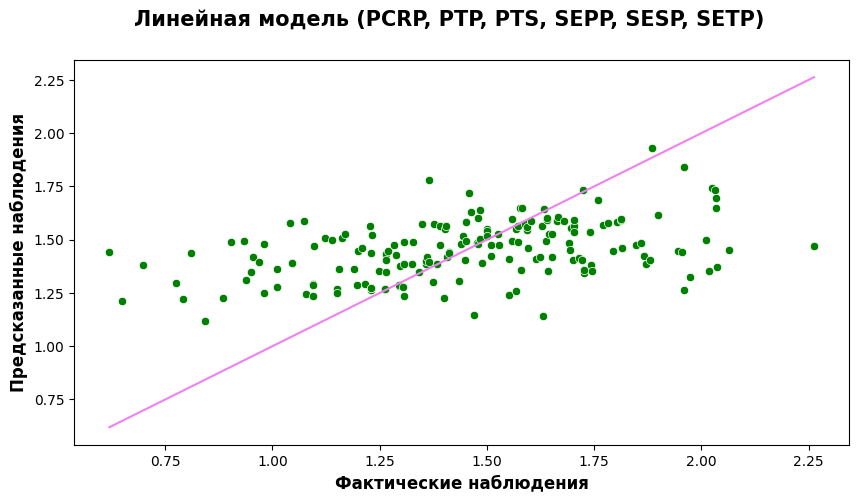

In [24]:
y_pred = regression.predict(x)
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=y, y=y_pred, ax=ax, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='violet')
fig.suptitle('Линейная модель (PCRP, PTP, PTS, SEPP, SESP, SETP)', fontsize=15, fontweight='bold')
ax.set_xlabel('Фактические наблюдения', fontsize=12, fontweight='bold')
ax.set_ylabel('Предсказанные наблюдения', fontsize=12, fontweight='bold')
plt.show()

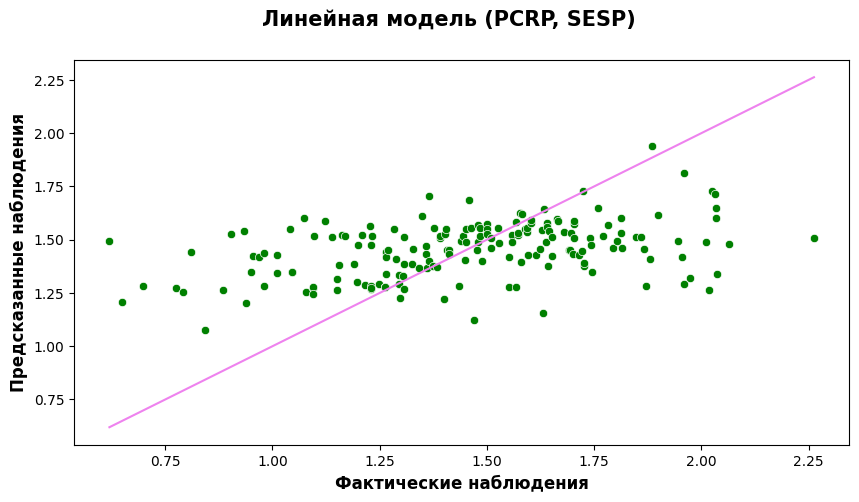

In [25]:
y1_pred = regression1.predict(x1)
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=y1, y=y1_pred, ax=ax, color='green')
plt.plot([y1.min(), y1.max()], [y1.min(), y1.max()], color='violet')
fig.suptitle('Линейная модель (PCRP, SESP)', fontsize=15, fontweight='bold')
ax.set_xlabel('Фактические наблюдения', fontsize=12, fontweight='bold')
ax.set_ylabel('Предсказанные наблюдения', fontsize=12, fontweight='bold')
plt.show()

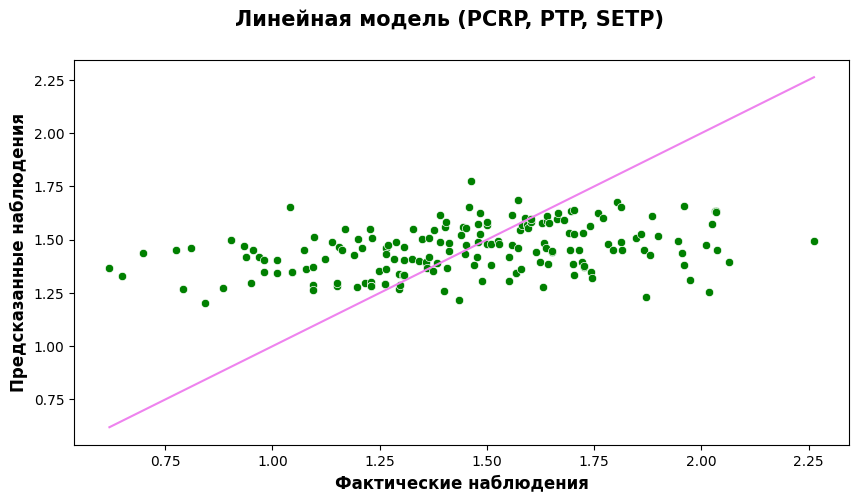

In [26]:
y2_pred = regression2.predict(x2)
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=y2, y=y2_pred, ax=ax, color='green')
plt.plot([y2.min(), y2.max()], [y2.min(), y2.max()], color='violet')
fig.suptitle('Линейная модель (PCRP, PTP, SETP)', fontsize=15, fontweight='bold')
ax.set_xlabel('Фактические наблюдения', fontsize=12, fontweight='bold')
ax.set_ylabel('Предсказанные наблюдения', fontsize=12, fontweight='bold')
plt.show()

Все модели плохо объясняют целевую переменную, так как визуально мы можем заметить, что точки далеки от биссектрисы.  

**Графики остатков модели**

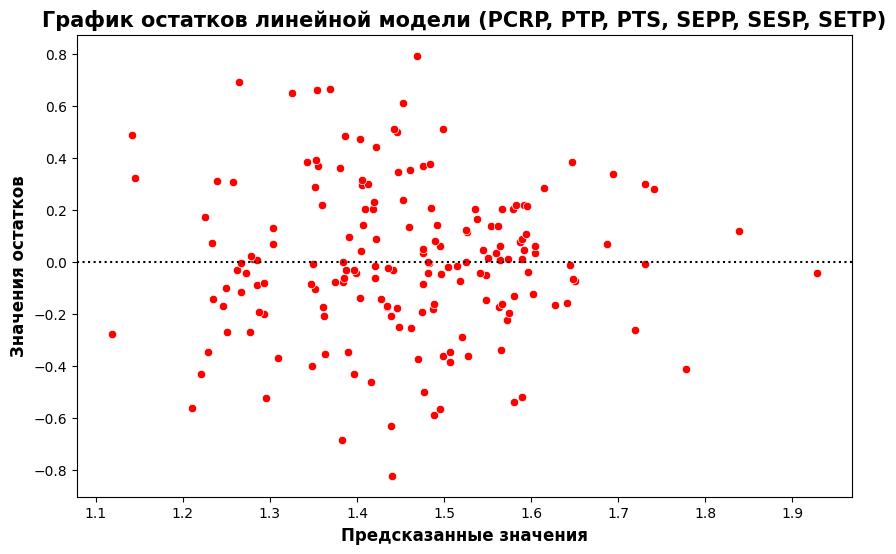

По тесту Шапиро-Уилка p-value составляет 0.4224


In [27]:
ostatki = regression.resid
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=ostatki, color='red')
plt.axhline(y=0, linestyle=':', color='black')
plt.xlabel('Предсказанные значения', fontsize=12, fontweight='bold')
plt.ylabel('Значения остатков', fontsize=12, fontweight='bold')
plt.title('График остатков линейной модели (PCRP, PTP, PTS, SEPP, SESP, SETP)', fontweight='bold', fontsize=15)
plt.show()
s1, pval1 = shapiro(ostatki)
print(f'По тесту Шапиро-Уилка p-value составляет {pval1:.4f}')

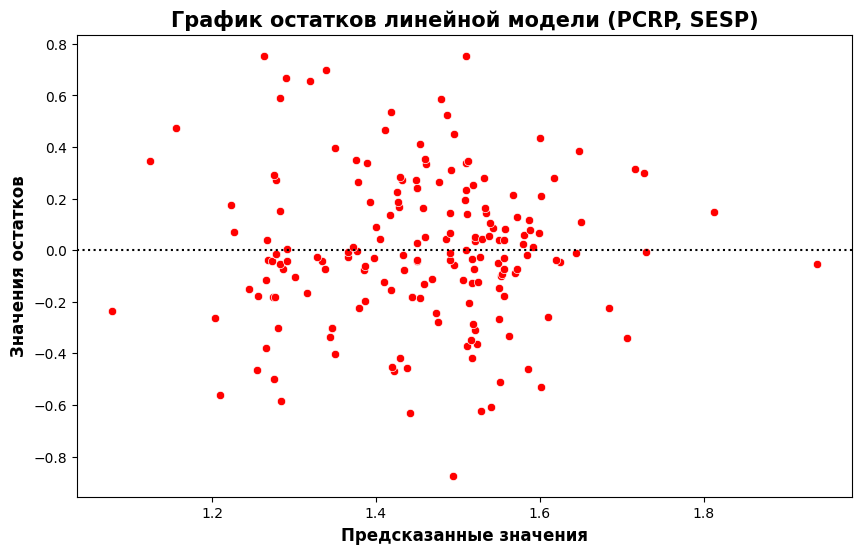

По тесту Шапиро-Уилка p-value составляет 0.3433


In [28]:
ostatki1 = regression1.resid
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y1_pred, y=ostatki1, color='red')
plt.axhline(y=0, linestyle=':', color='black')
plt.xlabel('Предсказанные значения', fontsize=12, fontweight='bold')
plt.ylabel('Значения остатков', fontsize=12, fontweight='bold')
plt.title('График остатков линейной модели (PCRP, SESP)', fontweight='bold', fontsize=15)
plt.show()
s1, pval1 = shapiro(ostatki1)
print(f'По тесту Шапиро-Уилка p-value составляет {pval1:.4f}')

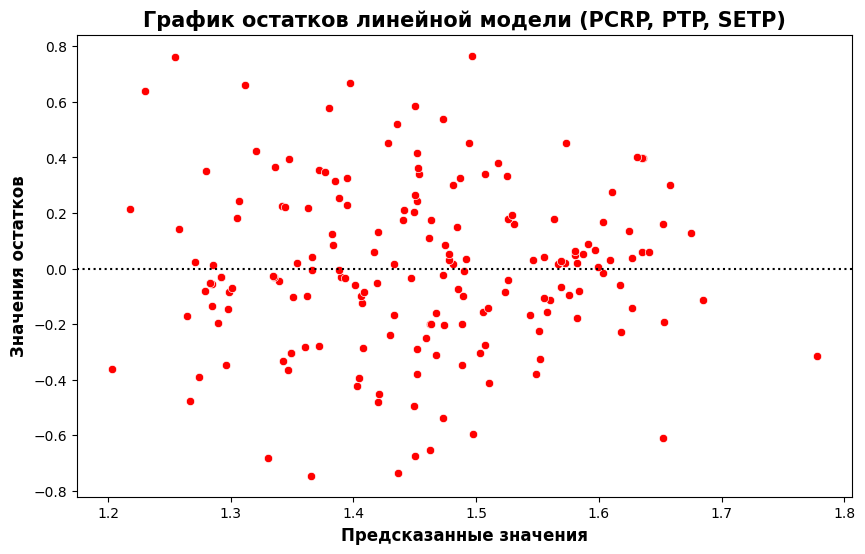

По тесту Шапиро-Уилка p-value составляет 0.5013


In [29]:
ostatki2 = regression2.resid
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y2_pred, y=ostatki2, color='red')
plt.axhline(y=0, linestyle=':', color='black')
plt.xlabel('Предсказанные значения', fontsize=12, fontweight='bold')
plt.ylabel('Значения остатков', fontsize=12, fontweight='bold')
plt.title('График остатков линейной модели (PCRP, PTP, SETP)', fontweight='bold', fontsize=15)
plt.show()
s1, pval1 = shapiro(ostatki2)
print(f'По тесту Шапиро-Уилка p-value составляет {pval1:.4f}')

После проведенного теста Шапиро-Уилка p-value распределения остатков по всем моделям составляет 0.4224,0.3433,0.5013 соответственно. Все тесты больше заданного уровня значимости 0.05, нулевая гипотеза не отвергается, следовательно у всех моделей остатки принадлежат нормальному закону распределения.

**Выводы:**
Линейная регрессия плохо предсказывает целевую переменную, однако среди моделей наилучшей является Линейная модель (PCRP, SESP) с Adj. R-squared:	0.163, так как она имеет лучшую объясняющую способность и не содержит признаки, которые приводят к мультиколлинеарности.

Положительный коэффициент указывает на прямую связь признака и целевой переменной, отрицательный - на обратную. Нельзя сделать выводы о силе влияния признака, так как переменные имеют различный масштаб.

# Регрессионный анализ. Нелинейная (степенная) регрессионная модель

**Степенная модель (PCRP, PTP, PTS, SEPP, SESP, SETP)**

In [30]:
log_df = np.log(df)
log_x = sm.add_constant(log_df[['PCRP', 'PTP', 'PTS', 'SEPP', 'SESP', 'SETP']])
log_y = log_df['GEPG']
log_model = sm.OLS(log_y, log_x).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GEPG   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     6.292
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           5.26e-06
Time:                        18:15:11   Log-Likelihood:                 21.395
No. Observations:                 181   AIC:                            -28.79
Df Residuals:                     174   BIC:                            -6.401
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0977      0.847     -0.115      0.908      -1.770       1.574
PCRP          -0.2460      0.169     -1.456      0.147      -0.579       0.087
PTP           -0.0072      0.068     -0.106      0.916      -0.142       0.128
PTS            0.0852      0.070      1.219      0.225      -0.053       0.223
SEPP          -0.0419      0.199     -0.210      0.834      -0.435       0.351
SESP           0.3354      0.094      3.574      0.000       0.150       0.521
SETP           0.0186      0.034      0.551      0.582      -0.048       0.085
==============================================================================
Omnibus:                       17.695   Durbin-Watson:                   0.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.491
Skew:                          -0.599   Prob(JB):                     4.81e-06
Kurtosis:                       4.346   Cond. No.                         501.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Степенная модель описывает **18%** общей вариации целевого признака (R-squared=0,178).
- P-value F статистики существенно меньше, чем 0,05 следовательно гипотеза о значимости коэффициента регрессии отвергается, можно сделать вывод, что **модель значима**.
- Однако если рассматривать переменные по отдельности, то гипотеза о незначимости коэффициента регрессии отвергается только для переменной SESP, следовательно только она является значимой. Таким образом модель плохо описывает целевую переменную.


\
\begin{aligned}
\text{Зависимая переменная} = &-0.0977 \\
&- 0.2460 \times \text{PCRP} \\
&- 0.0072 \times \text{PTP} \\
&+ 0.0852 \times \text{PTS} \\
&- 0.0419 \times \text{SEPP} \\
&+ 0.3354 \times \text{SESP} \\
&+ 0.0186 \times \text{SETP}
\end{aligned}



**Степенная модель (PCRP, SESP)**

In [31]:
log_df = np.log(df)
log_x1 = sm.add_constant(log_df[['PCRP', 'SESP']])
log_y1 = log_df['GEPG']
log_model1 = sm.OLS(log_y1, log_x1).fit()
log_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GEPG   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     17.93
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           8.05e-08
Time:                        18:15:11   Log-Likelihood:                 20.235
No. Observations:                 181   AIC:                            -34.47
Df Residuals:                     178   BIC:                            -24.87
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0602      0.488     -0.123      0.902      -1.023       0.903
PCRP          -0.2196      0.151     -1.458      0.147      -0.517       0.078
SESP           0.3188      0.066      4.812      0.000       0.188       0.450
==============================================================================
Omnibus:                       16.851   Durbin-Watson:                   0.351
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.170
Skew:                          -0.597   Prob(JB):                     1.53e-05
Kurtosis:                       4.231   Cond. No.                         199.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Степенная модель описывает **17%** общей вариации целевого признака(R-squared=0,168).

\begin{aligned}
\text{Зависимая переменная} = &-0.0602 \\
&- 0.2196 \times \text{PCRP} \\
&+ 0.3188 \times \text{SESP}
\end{aligned}



**Степенная модель (PCRP, PTP, SETP)**

In [32]:
log_df = np.log(df)
log_x2 = sm.add_constant(log_df[['PCRP', 'PTP', 'SETP']])
log_y2 = log_df['GEPG']
log_model2 = sm.OLS(log_y2, log_x2).fit()
log_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   GEPG   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     7.650
Date:                Sun, 23 Mar 2025   Prob (F-statistic):           7.75e-05
Time:                        18:15:11   Log-Likelihood:                 14.658
No. Observations:                 181   AIC:                            -21.32
Df Residuals:                     177   BIC:                            -8.522
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2649      0.656      0.404      0.687      -1.029       1.559
PCRP           0.0035      0.142      0.025      0.980      -0.276       0.283
PTP           -0.0611      0.050     -1.227      0.221      -0.159       0.037
SETP           0.0731      0.030      2.418      0.017       0.013       0.133
==============================================================================
Omnibus:                       17.999   Durbin-Watson:                   0.223
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               21.645
Skew:                          -0.684   Prob(JB):                     1.99e-05
Kurtosis:                       3.999   Cond. No.                         260.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Степенная модель описывает **12%** общей вариации целевого признака (R-squared=0,115).
На основе предоставленных данных, уравнение регрессии можно записать следующим образом:

\begin{aligned}
\text{Зависимая переменная} = &0.2649 \\
&+ 0.0035 \times \text{PCRP} \\
&- 0.0611 \times \text{PTP} \\
&+ 0.0731 \times \text{SETP}
\end{aligned}

Таким образом все модели плохо писывают целевую переменную, но исходя из наших трех моделей, лучшая модель описывает 18% общей вариации целевого признака- (PCRP, PTP, PTS, SEPP, SETP, SESP). На втором месте (PCRP,SESP)- 17 % и затем модель (PCRP, PTP, SETP)-12%



**Графики предсказанных и фатических значений**

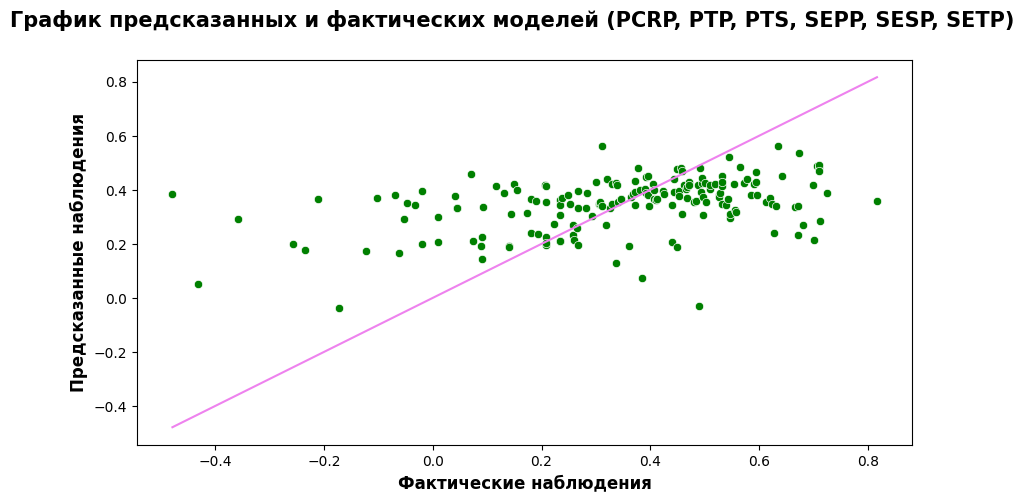

In [33]:
y_log_pred = log_model.predict(log_x)
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=log_y, y=y_log_pred, ax=ax, color='green')
plt.plot([log_y.min(), log_y.max()], [log_y.min(), log_y.max()], color='violet')
fig.suptitle('График предсказанных и фактических моделей (PCRP, PTP, PTS, SEPP, SESP, SETP)', fontsize=15, fontweight='bold')
ax.set_xlabel('Фактические наблюдения', fontsize=12, fontweight='bold')
ax.set_ylabel('Предсказанные наблюдения', fontsize=12, fontweight='bold')
plt.show()

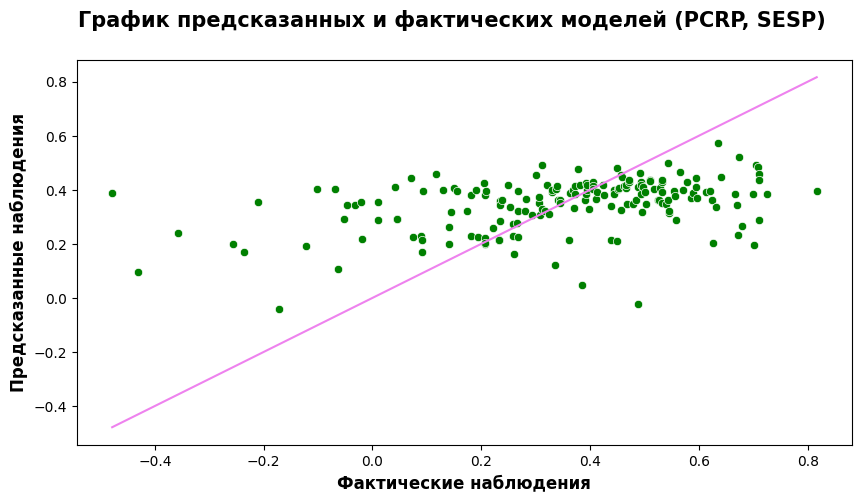

In [34]:
y1_log_pred = log_model1.predict(log_x1)
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=log_y1, y=y1_log_pred, ax=ax, color='green')
plt.plot([log_y1.min(), log_y1.max()], [log_y1.min(), log_y1.max()], color='violet')
fig.suptitle('График предсказанных и фактических моделей (PCRP, SESP)', fontsize=15, fontweight='bold')
ax.set_xlabel('Фактические наблюдения', fontsize=12, fontweight='bold')
ax.set_ylabel('Предсказанные наблюдения', fontsize=12, fontweight='bold')
plt.show()

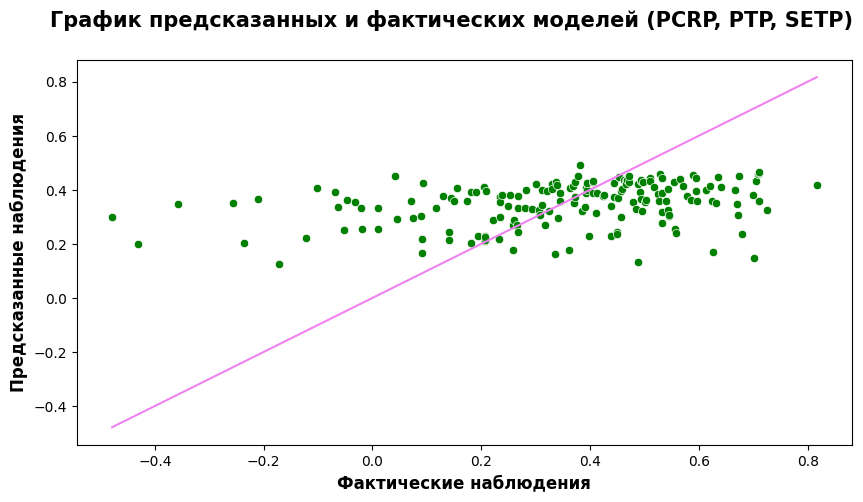

In [35]:
y2_log_pred = log_model2.predict(log_x2)
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=log_y2, y=y2_log_pred, ax=ax, color='green')
plt.plot([log_y2.min(), log_y2.max()], [log_y2.min(), log_y2.max()], color='violet')
fig.suptitle('График предсказанных и фактических моделей (PCRP, PTP, SETP)', fontsize=15, fontweight='bold')
ax.set_xlabel('Фактические наблюдения', fontsize=12, fontweight='bold')
ax.set_ylabel('Предсказанные наблюдения', fontsize=12, fontweight='bold')
plt.show()

**Графики остатков для степенной модели**

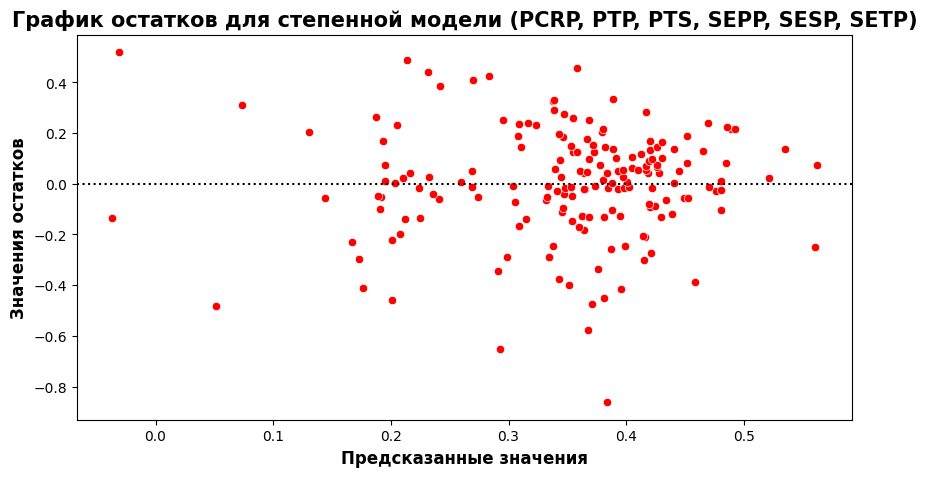

По тесту Шапиро-Уилка p-value составляет 0.0014


In [36]:
log_residuals = log_model.resid
log_y_pred = log_model.predict(log_x)
plt.figure(figsize=(10,5))
sns.scatterplot(x=log_y_pred, y=log_residuals, color='red')
plt.axhline(y=0, color='black', linestyle=':')
plt.xlabel('Предсказанные значения', fontsize=12, fontweight='bold')
plt.ylabel('Значения остатков', fontsize=12, fontweight='bold')
plt.title('График остатков для степенной модели (PCRP, PTP, PTS, SEPP, SESP, SETP)', fontsize=15, fontweight='bold')
plt.show()
s2, pval2 = shapiro(log_residuals)
print(f'По тесту Шапиро-Уилка p-value составляет {pval2:.4f}')

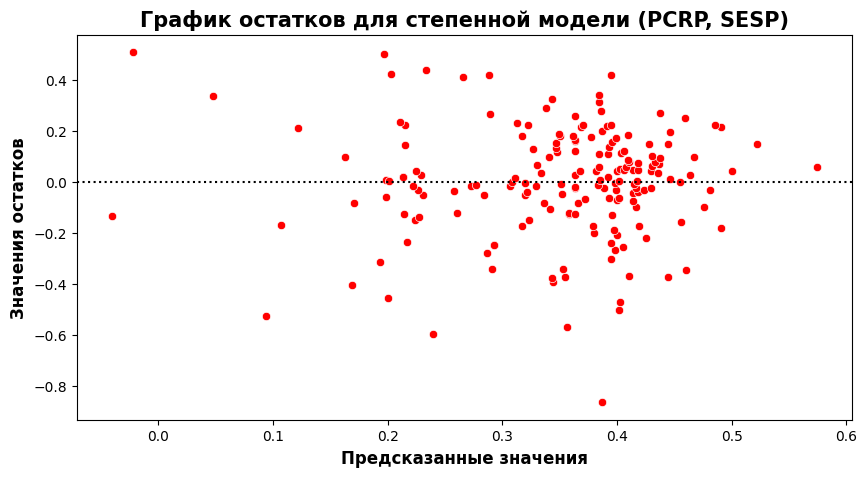

По тесту Шапиро-Уилка p-value составляет 0.0013


In [37]:
log_residuals1 = log_model1.resid
log_y1_pred = log_model1.predict(log_x1)
plt.figure(figsize=(10,5))
sns.scatterplot(x=log_y1_pred, y=log_residuals1, color='red')
plt.axhline(y=0, color='black', linestyle=':')
plt.xlabel('Предсказанные значения', fontsize=12, fontweight='bold')
plt.ylabel('Значения остатков', fontsize=12, fontweight='bold')
plt.title('График остатков для степенной модели (PCRP, SESP)', fontsize=15, fontweight='bold')
plt.show()
s2, pval2 = shapiro(log_residuals1)
print(f'По тесту Шапиро-Уилка p-value составляет {pval2:.4f}')

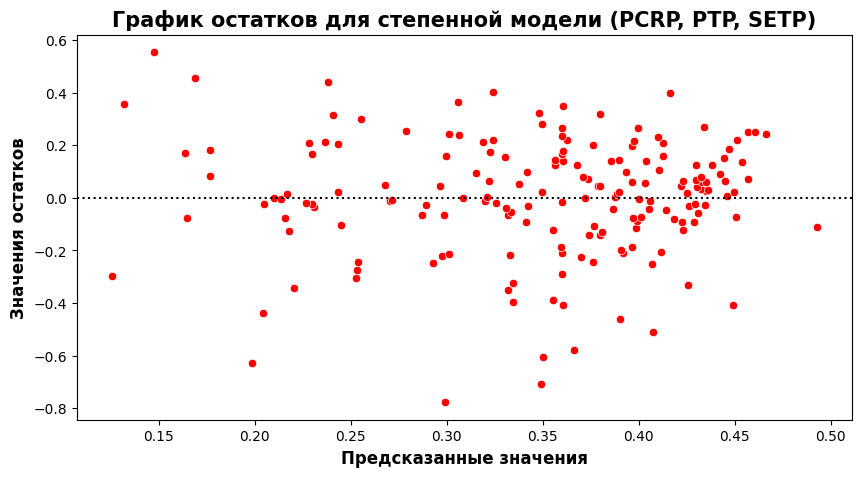

По тесту Шапиро-Уилка p-value составляет 0.0006


In [38]:
log_residuals2 = log_model2.resid
log_y2_pred = log_model2.predict(log_x2)
plt.figure(figsize=(10,5))
sns.scatterplot(x=log_y2_pred, y=log_residuals2, color='red')
plt.axhline(y=0, color='black', linestyle=':')
plt.xlabel('Предсказанные значения', fontsize=12, fontweight='bold')
plt.ylabel('Значения остатков', fontsize=12, fontweight='bold')
plt.title('График остатков для степенной модели (PCRP, PTP, SETP)', fontsize=15, fontweight='bold')
plt.show()
s2, pval2 = shapiro(log_residuals2)
print(f'По тесту Шапиро-Уилка p-value составляет {pval2:.4f}')

- По графику остатков для всех трех моделей мы видим, что **данные не гомоскедастичны**: на графике наблюдения неравномерно распределены вокруг нулевой линии, дисперсия остатков неодинакова для разных переменных.
- Тест Шапиро - Уилка для каждой модели отвергается. Для модели (PCRP, PTP, PTS, SEPP, SETP, SESP) p-value составляет 0.0014, для модели (PCRP,SESP) p-value = 0,0013, для модели  (PCRP, PTP, SETP) p-value = 0,0006.


**Выводы:**
Степенная модель не улучшила точность описания данных. Возможно, построение иной нелинейной регресии могло бы улучшить модель.

Положительный коэффициент указывает на прямую связь признака и целевой переменной, отрицательный - на обратную. Нельзя сделать выводы о силе влияния признака, так как переменные имеют различный масштаб.

# Итоги

Так как модели имеют различное число признаков, то справедливым является сравнение по Adj. R-squared, в таком случае лучшей регрессией является линейная модель (PCRP, SESP) с Adj. R-squared 0,163. Однако её предсказывающая способность всё ещё невелика.

GEPG=1.2523-0.0036PCRP+0.0062SESP

На государственные расходы на образование в процентах от ВВП положительно влияет уровень зачисления в среднюю школу в процентах от населения и отрицательно влияет уровень завершения начальной школы в процентах от соответствующей возрастной группы.

На основе полученных данных можно сделать следующие выводы:
1. Финансирование не является прямым драйвером улучшения доступности образования (например, рост расходов не гарантирует повышения охвата школами).

2. Приоритеты расходов могут быть направлены на другие аспекты, такие как инфраструктура, зарплаты учителей, цифровизация или программы повышения качества, которые не отражаются в анализируемых признаках.

3. Простое увеличение финансирования не решает системных проблем образования. Например, даже при высоких расходах сохраняются низкие показатели завершения школы из-за культурных, социальных или управленческих барьеров.

4. Ключевое значение имеют институциональные факторы: прозрачность распределения средств, борьба с коррупцией, качество управления и мониторинга результатов.

5. Возможный "эффект запаздывания"
Результаты инвестиций в образование часто проявляются через годы или десятилетия. Увеличение расходов сегодня может повлиять на уровень грамотности или ВВП только в долгосрочной перспективе.